In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

import scipy.stats as st

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [18]:
# import SSH data

files = glob.glob('../data/sla/*.nc')
#print files

Tok1_SSH = Dataset(files[0], mode='r')

slaT = ma.getdata(np.squeeze(Tok1_SSH.variables['sla'][:]))

lons = Tok1_SSH.variables['lon'][:]
lats = Tok1_SSH.variables['lat'][:]

ncp = Tok1['Air-sea flux'].values
temp = Tok1['T'].values

Tok1_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok1['Lon'].values
ynew = Tok1['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    o = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        ncp_track.append(m)
        temp_track.append(o)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track 
dtabT1 = dtab.dropna()

subset = dtabT1[dtabT1['temp']<18]

mx, cx, rx, px, std_err = st.linregress(subset['sla'], subset['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px<0.05

# plt.plot(np.arange(-0.6, 0.8, 0.01), mx*np.arange(-0.6, 0.8, 0.01)+cx, 'r')
# plt.show()

estimated slope =  -175.717108138 , r =  -0.77338077543 , p-value < 0.05  True


In [4]:
Tok3_SSH = Dataset(files[2], mode='r')
slaT = np.squeeze(Tok3_SSH.variables['sla'][:])
lons = Tok3_SSH.variables['lon'][:]
lats = Tok3_SSH.variables['lat'][:]

ncp = Tok3['Air-sea flux'].values

Tok3_SSH.close()

ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok3['Lon'].values
ynew = Tok3['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)


dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat

dtabT3 = dtab.dropna()

# mx, cx, rx, px, std_err = st.linregress(dtab['sla'], dtab['ncp'])
# print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px<0.05

# plt.plot(np.arange(-0.6, 0.8, 0.01), mx*np.arange(-0.6, 0.8, 0.01)+cx, 'r')
# plt.show()


In [13]:
T_SSH = Dataset(files[5], mode='r')
slaT = np.squeeze(T_SSH.variables['sla'][:])
lons = T_SSH.variables['lon'][:]
lats = T_SSH.variables['lat'][:]

ncp = Tian['Air-sea flux'].values
temp = Tian['T'].values

T_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tian['Lon'].values
ynew = Tian['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    p = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        temp_track.append(p)
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(new_lat, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track
dtabTian = dtab.dropna()

mx, cx, rx, px, std_err = st.linregress(dtab['sla'], dtab['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px<0.05

# #plt.plot(np.arange(34, 42, 0.5), mx*np.arange(34, 42, 0.5)+cx, 'r')
# plt.show()


estimated slope =  nan , r =  nan , p-value < 0.05  False


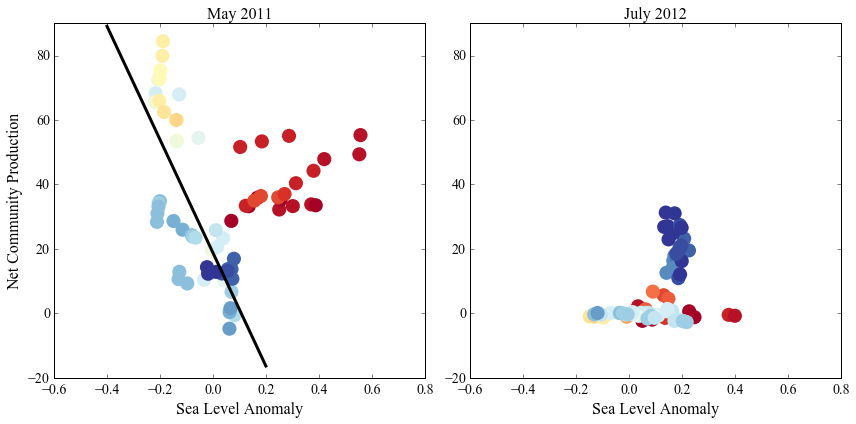

In [23]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP
palette = plt.get_cmap('RdYlBu_r', 30)
# fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig1, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)


ax1.scatter(dtabT1['sla'], dtabT1['ncp'], s=200, c=dtabT1['temp'] , lw = 0, cmap = palette)

ax1.plot(np.arange(-0.4, 0.2, 0.01), mx*np.arange(-0.4, 0.2, 0.01)+cx, 'k', lw =3)


ax1.set_xlim([-0.6, 0.8])
ax1.set_ylim([-20, 90])
ax1.set_ylabel('Net Community Production', fontsize=16)
ax1.set_xlabel('Sea Level Anomaly', fontsize = 16)
ax1.set_title('May 2011', fontsize = 16)
ax1.tick_params(labelsize = 14)

# ax2.plot(dtabT3['sla'], dtabT3['ncp'], '.k', lw = 0, markersize = 10)
# ax2.set_xlim([-0.6, 0.8])
# ax2.set_ylim([-20, 90])
# ax2.set_xlabel('Sea Level Anomaly (m)', fontsize=16)
# ax2.set_title('September 2011', fontsize = 16)
# ax2.tick_params(labelsize = 14)

ax3.scatter(dtabTian['sla'], dtabTian['ncp'], s=200, c=dtabTian['temp'], lw = 0, cmap = palette)
ax3.set_xlim([-0.6, 0.8])
ax3.set_ylim([-20, 90])
ax3.set_title('July 2012', fontsize = 16)
ax3.tick_params(labelsize = 14)
ax3.set_xlabel('Sea Level Anomaly', fontsize = 16)

plt.show()

#fig1.savefig('../figures/NCP_SLA_scatter.png', dpi = 300)

In [ ]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP

# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig2, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)


ax1.plot(Tok1['Lat'], Tok1['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax1.set_xlim([32, 46])
ax1.set_ylim([-20, 90])
ax1.set_ylabel('Net Community Production', fontsize=16)
ax1.set_title('May 2011', fontsize = 16)
ax1.tick_params(labelsize = 14)

# ax2.plot(Tok3['Lat'], Tok3['Air-sea flux'], '.k', lw = 0, markersize = 10)
# ax2.set_xlim([32, 46])
# ax2.set_ylim([-20, 90])
# ax2.set_xlabel('Latitude ($^o$)', fontsize=16)
# ax2.set_title('September 2011', fontsize = 16)
# ax2.tick_params(labelsize = 14)

ax3.plot(Tian['Lat'], Tian['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax3.set_xlim([32, 46])
ax3.set_ylim([-20, 90])
ax3.set_title('July 2012', fontsize = 16)
ax3.tick_params(labelsize = 14)

plt.show()

#fig2.savefig('../figures/NCP_LAT_scatter.png', dpi = 300)